## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn for ML learners
from sklearn.ensemble import RandomForestRegressor

# dmlkappa package
from dmlkappa import simulate_plr, DMLKappaPLR

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

## 2. Well-Conditioned Scenario: High Overlap

When there is **high overlap** (large residual variation in treatment after partialling out X), the DML estimator is well-conditioned. This means:
- κ_DML is close to 1
- Standard errors are reliable
- Confidence intervals have good coverage

In [2]:
# Simulate PLR data with HIGH overlap
X_high, D_high, Y_high, info_high = simulate_plr(
    n=1000,
    p=10,
    rho=0.5,
    overlap="high",    # <-- high overlap -> well-conditioned
    theta0=1.0,
    random_state=SEED
)

print("DGP parameters (high overlap):")
print(f"  True θ₀ = {info_high['theta0']}")
print(f"  Overlap = {info_high['overlap']} (σ_U = {info_high['sigma_u']})")
print(f"  Correlation ρ = {info_high['rho']}")

DGP parameters (high overlap):
  True θ₀ = 1.0
  Overlap = high (σ_U = 2.0)
  Correlation ρ = 0.5


In [3]:
# Fit DML-PLR with Random Forest learners
model_high = DMLKappaPLR(
    learner_m=RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=SEED),
    learner_g=RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=SEED),
    n_splits=5,
    random_state=SEED
)
model_high.fit(X_high, D_high, Y_high)

# Print full summary
print(model_high.summary())

DML-PLR Estimation Results with κ_DML Diagnostics
  θ̂ (treatment effect)    : 0.958528
  Standard error          : 0.017795
  95% Confidence interval : [0.923651, 0.993406]
------------------------------------------------------------
Finite-Sample Conditioning Diagnostics
------------------------------------------------------------
  κ_DML                   : 0.2483
  Regime                  : well conditioned
  Effective sample size   : 941.9
  Var(Û)                  : 4.027137


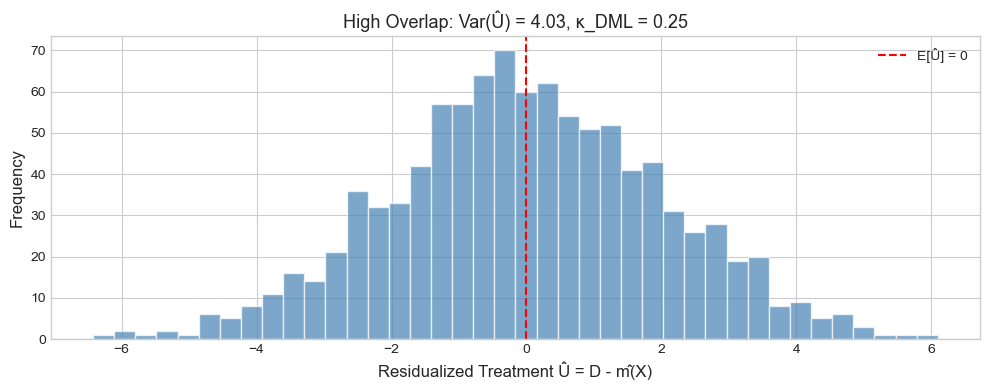

In [4]:
# Visualize the residualized treatments Û
fig, ax = plt.subplots()
ax.hist(model_high.u_hat_, bins=40, alpha=0.7, color='steelblue', edgecolor='white')
ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='E[Û] = 0')
ax.set_xlabel('Residualized Treatment Û = D - m̂(X)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'High Overlap: Var(Û) = {np.var(model_high.u_hat_):.2f}, κ_DML = {model_high.kappa_:.2f}', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation**: With high overlap, Var(Û) is large, so κ_DML ≈ n / Σ Û² is small. The regime is "well-conditioned" and standard DML inference should be reliable.

## 3. Severely Ill-Conditioned Scenario: Low Overlap

When there is **low overlap** (small residual variation in treatment), the DML estimator becomes ill-conditioned:
- κ_DML is large
- Standard errors may understate true uncertainty
- Confidence intervals may undercover

In [5]:
# Simulate PLR data with LOW overlap
X_low, D_low, Y_low, info_low = simulate_plr(
    n=1000,
    p=10,
    rho=0.9,           # <-- higher correlation makes prediction easier
    overlap="low",     # <-- low overlap -> ill-conditioned
    theta0=1.0,
    random_state=SEED
)

print("DGP parameters (low overlap):")
print(f"  True θ₀ = {info_low['theta0']}")
print(f"  Overlap = {info_low['overlap']} (σ_U = {info_low['sigma_u']})")
print(f"  Correlation ρ = {info_low['rho']}")

DGP parameters (low overlap):
  True θ₀ = 1.0
  Overlap = low (σ_U = 0.3)
  Correlation ρ = 0.9


In [6]:
# Fit DML-PLR
model_low = DMLKappaPLR(
    learner_m=RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=SEED),
    learner_g=RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=SEED),
    n_splits=5,
    random_state=SEED
)
model_low.fit(X_low, D_low, Y_low)

# Print full summary
print(model_low.summary())

DML-PLR Estimation Results with κ_DML Diagnostics
  θ̂ (treatment effect)    : 0.815800
  Standard error          : 0.111196
  95% Confidence interval : [0.597860, 1.033740]
------------------------------------------------------------
Finite-Sample Conditioning Diagnostics
------------------------------------------------------------
  κ_DML                   : 10.7134
  Regime                  : severely ill conditioned
  Effective sample size   : 8.6
  Var(Û)                  : 0.093334


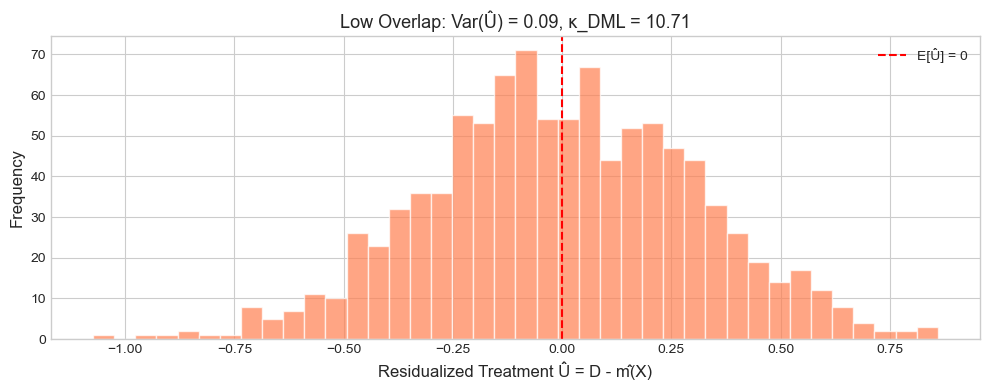

In [7]:
# Visualize the residualized treatments Û
fig, ax = plt.subplots()
ax.hist(model_low.u_hat_, bins=40, alpha=0.7, color='coral', edgecolor='white')
ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='E[Û] = 0')
ax.set_xlabel('Residualized Treatment Û = D - m̂(X)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Low Overlap: Var(Û) = {np.var(model_low.u_hat_):.2f}, κ_DML = {model_low.kappa_:.2f}', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation**: With low overlap, Var(Û) is small, so κ_DML is large. The regime is "severely ill-conditioned." Even though DML is asymptotically valid, finite-sample performance may be poor.

## 4. Side-by-Side Comparison

Let's compare the two scenarios in a summary table:

In [8]:
# Build comparison table
comparison = pd.DataFrame({
    'Scenario': ['High Overlap', 'Low Overlap'],
    'θ̂': [model_high.theta_hat_, model_low.theta_hat_],
    'SE': [model_high.se_, model_low.se_],
    '95% CI Lower': [model_high.ci_()[0], model_low.ci_()[0]],
    '95% CI Upper': [model_high.ci_()[1], model_low.ci_()[1]],
    'κ_DML': [model_high.kappa_, model_low.kappa_],
    'Regime': [model_high.regime_label(), model_low.regime_label()],
    'Effective n': [model_high.diagnostics_['effective_n'], model_low.diagnostics_['effective_n']]
})

# Round for display
comparison = comparison.round(4)
print(comparison.to_string(index=False))

    Scenario     θ̂     SE  95% CI Lower  95% CI Upper   κ_DML                   Regime  Effective n
High Overlap 0.9585 0.0178        0.9237        0.9934  0.2483         well conditioned     941.9212
 Low Overlap 0.8158 0.1112        0.5979        1.0337 10.7134 severely ill conditioned       8.6373


/var/folders/w9/87d44l6n0s9dznd5xl5dsjnm0000gn/T/ipykernel_38371/2340620463.py:30: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/gabrielsaco/anaconda3/envs/kappa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


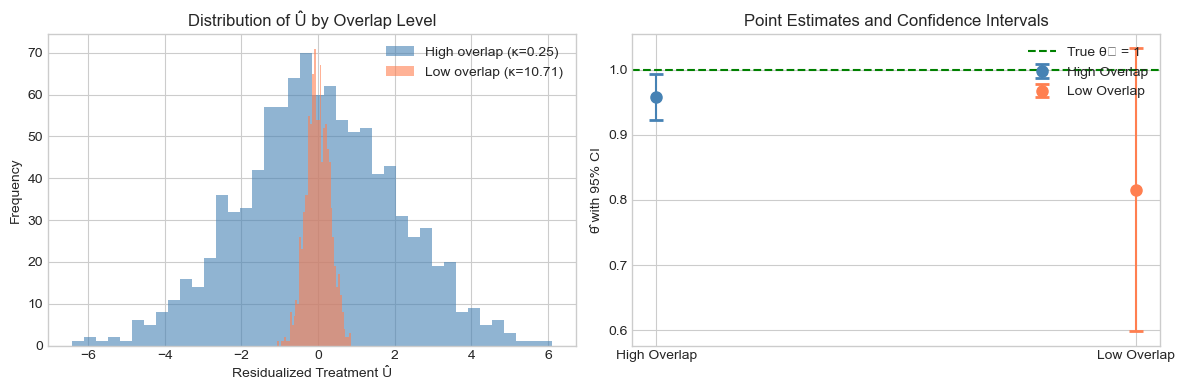

In [9]:
# Visualize κ_DML comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Histogram comparison
axes[0].hist(model_high.u_hat_, bins=40, alpha=0.6, label=f'High overlap (κ={model_high.kappa_:.2f})', color='steelblue')
axes[0].hist(model_low.u_hat_, bins=40, alpha=0.6, label=f'Low overlap (κ={model_low.kappa_:.2f})', color='coral')
axes[0].set_xlabel('Residualized Treatment Û')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Û by Overlap Level')
axes[0].legend()

# Right: CI comparison
scenarios = ['High Overlap', 'Low Overlap']
thetas = [model_high.theta_hat_, model_low.theta_hat_]
ci_lows = [model_high.ci_()[0], model_low.ci_()[0]]
ci_highs = [model_high.ci_()[1], model_low.ci_()[1]]
colors = ['steelblue', 'coral']

for i, (scenario, theta, ci_l, ci_h, color) in enumerate(zip(scenarios, thetas, ci_lows, ci_highs, colors)):
    axes[1].errorbar(i, theta, yerr=[[theta - ci_l], [ci_h - theta]], 
                     fmt='o', capsize=5, capthick=2, markersize=8, color=color, label=scenario)

axes[1].axhline(1.0, color='green', linestyle='--', linewidth=1.5, label='True θ₀ = 1')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(scenarios)
axes[1].set_ylabel('θ̂ with 95% CI')
axes[1].set_title('Point Estimates and Confidence Intervals')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 5. Key Takeaways

**Same DML pipeline, different κ_DML → very different finite-sample reliability.**

- **High overlap** (σ_U large) → Var(Û) large → **κ_DML small** → well-conditioned → reliable inference
- **Low overlap** (σ_U small) → Var(Û) small → **κ_DML large** → ill-conditioned → unreliable inference

The condition number κ_DML is a simple, interpretable diagnostic that:
1. Can be computed from the fitted model residuals
2. Does not require knowledge of the true parameter
3. Provides guidance on when to trust (or question) DML inference

**Recommendations when κ_DML is large:**
- Increase sample size if possible
- Use more flexible ML learners to reduce Û variance
- Consider alternative estimators designed for weak overlap
- Report κ_DML alongside standard errors and CIs